# 🎯 Xception: Deep Learning with Depthwise Separable Convolutions

## Part 3: Grad-CAM, Feature Maps, Experimental Results & Conclusions

---

**👨‍🎓 Sunan:** Çağatay ÜRESİN  
**📅 Tarih:** 17 Aralık 2025  
**📧 GitHub:** [@cagatayuresin](https://github.com/cagatayuresin)

---

### 📖 Bu Part'ta Neler Var?

1. **Grad-CAM Visualization:** Model hangi bölgelere bakıyor?
2. **Feature Map Analysis:** İç katmanlar ne öğreniyor?
3. **Experimental Results:** ImageNet ve JFT performans grafikleri
4. **Ablation Studies:** Residual connections, intermediate activations
5. **Conclusions:** Ana çıkarımlar ve gelecek yönelimler
6. **Modern Impact:** MobileNet, EfficientNet'e etkisi

---

## 📦 Kütüphaneleri İçe Aktarma

In [1]:
# Temel kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image
import io
import requests
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# OpenCV
import cv2

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Kütüphaneler yüklendi!")
print(f"🔧 TensorFlow: {tf.__version__}")

✅ Kütüphaneler yüklendi!
🔧 TensorFlow: 2.19.0


## 🔄 Model ve Test Görüntüsü Yükleme

(Part 2'den devam)

In [2]:
# Xception model yükle
print("🔥 Pre-trained Xception Model Yükleniyor...\n")

xception_model = Xception(
    include_top=True,
    weights='imagenet',
    input_shape=(299, 299, 3),
    classes=1000
)

print("✅ Model yüklendi!")
print(f"Total layers: {len(xception_model.layers)}")
print(f"Total parameters: {xception_model.count_params():,}")

🔥 Pre-trained Xception Model Yükleniyor...

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model yüklendi!
Total layers: 134
Total parameters: 22,910,480


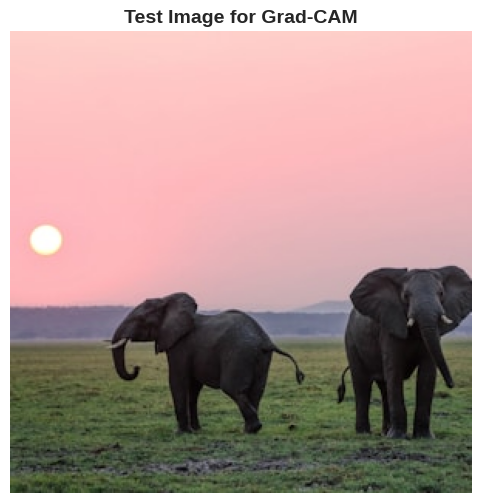

✅ Test image shape: (299, 299, 3)


In [3]:
# Test görüntüsü yükle
def load_test_image(image_choice='cat'):
    image_urls = {
        'cat': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=299&h=299&fit=crop',
        'dog': 'https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=299&h=299&fit=crop',
        'elephant': 'https://images.unsplash.com/photo-1564760055775-d63b17a55c44?w=299&h=299&fit=crop',
        'tiger': 'https://images.unsplash.com/photo-1561731216-c3a4d99437d5?w=299&h=299&fit=crop'
    }

    url = image_urls.get(image_choice, image_urls['cat'])

    try:
        response = requests.get(url, timeout=10)
        img = Image.open(io.BytesIO(response.content))
        img = img.convert('RGB')
        img = img.resize((299, 299), Image.Resampling.LANCZOS)
        return np.array(img)
    except:
        return np.random.randint(0, 255, (299, 299, 3), dtype=np.uint8)

# Test image
test_image = load_test_image('elephant')

plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title('Test Image for Grad-CAM', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

print(f"✅ Test image shape: {test_image.shape}")

---

# 🎨 BÖLÜM 1: Grad-CAM Visualization

## 1.1 Grad-CAM Nedir?

**Gradient-weighted Class Activation Mapping (Grad-CAM):**

Model tahminini yaparken **hangi bölgelere baktığını** gösteren bir görselleştirme tekniği.

### Nasıl Çalışır?

1. Model'den bir prediction al
2. Son convolutional layer'ın output'unu al
3. Predicted class için gradient'leri hesapla
4. Gradient'leri global average pooling ile ağırlıklandır
5. Weighted feature maps'i topla
6. ReLU uygula (pozitif contributions)
7. Heatmap olarak görselleştir

### Matematiksel Formül:

$$L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_k \alpha_k^c A^k\right)$$

Burada:
- $c$: target class
- $A^k$: k'inci feature map
- $\alpha_k^c = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A_{ij}^k}$: gradient weights

---

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Grad-CAM heatmap oluştur

    Args:
        img_array: Input image (preprocessed)
        model: Keras model
        last_conv_layer_name: Son conv layer'ın adı
        pred_index: Target class index (None ise top prediction)

    Returns:
        heatmap: Grad-CAM heatmap (0-255 range)
    """
    # Gradient model oluştur
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Gradient hesapla
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient'leri conv output'a göre hesapla
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling (her channel için)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted sum of feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU (sadece pozitif contributions)
    heatmap = tf.maximum(heatmap, 0)

    # Normalize [0, 1]
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy()


def display_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Grad-CAM heatmap'i orijinal görüntüyle overlay et

    Args:
        img: Original image (0-255)
        heatmap: Grad-CAM heatmap (0-1)
        alpha: Overlay transparency
        colormap: OpenCV colormap

    Returns:
        Superimposed image
    """
    # Heatmap'i resize et
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Heatmap'i 0-255 range'e çevir
    heatmap = np.uint8(255 * heatmap)

    # Colormap uygula
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # BGR to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img


print("✅ Grad-CAM fonksiyonları tanımlandı!")

✅ Grad-CAM fonksiyonları tanımlandı!


## 1.2 Xception Model için Grad-CAM

Xception'ın son convolutional layer'ını bulalım ve Grad-CAM uygulayalım.

In [6]:
# Son conv layer'ı bul
print("🔍 Son convolutional layer'ı buluyoruz...\n")

last_conv_layer_name = None
for layer in reversed(xception_model.layers):
    # SeparableConv2D veya Conv2D ara
    if isinstance(layer, (tf.keras.layers.SeparableConv2D, tf.keras.layers.Conv2D)):
        last_conv_layer_name = layer.name
        print(f"✅ Son conv layer bulundu: {last_conv_layer_name}")
        print(f"   Layer type: {type(layer).__name__}")
        print(f"   Output shape: {layer.output.shape}") # Changed from layer.output_shape
        break

if last_conv_layer_name is None:
    print("❌ Convolutional layer bulunamadı!")
else:
    # Preprocess image
    img_preprocessed = preprocess_input(test_image.copy())
    img_array = np.expand_dims(img_preprocessed, axis=0)

    # Prediction
    preds = xception_model.predict(img_array, verbose=0)
    top_pred = decode_predictions(preds, top=1)[0][0]

    print(f"\n🔮 Top Prediction: {top_pred[1].replace('_', ' ').title()} ({top_pred[2]*100:.2f}%)")

    # Generate Grad-CAM
    print("\n🎨 Grad-CAM hesaplanıyor...")
    heatmap = make_gradcam_heatmap(img_array, xception_model, last_conv_layer_name)

    print(f"✅ Heatmap shape: {heatmap.shape}")
    print(f"   Value range: [{heatmap.min():.3f}, {heatmap.max():.3f}]")

🔍 Son convolutional layer'ı buluyoruz...

✅ Son conv layer bulundu: block14_sepconv2
   Layer type: SeparableConv2D
   Output shape: (None, 10, 10, 2048)
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔮 Top Prediction: African Elephant (77.79%)

🎨 Grad-CAM hesaplanıyor...
✅ Heatmap shape: (10, 10)
   Value range: [0.000, 1.000]


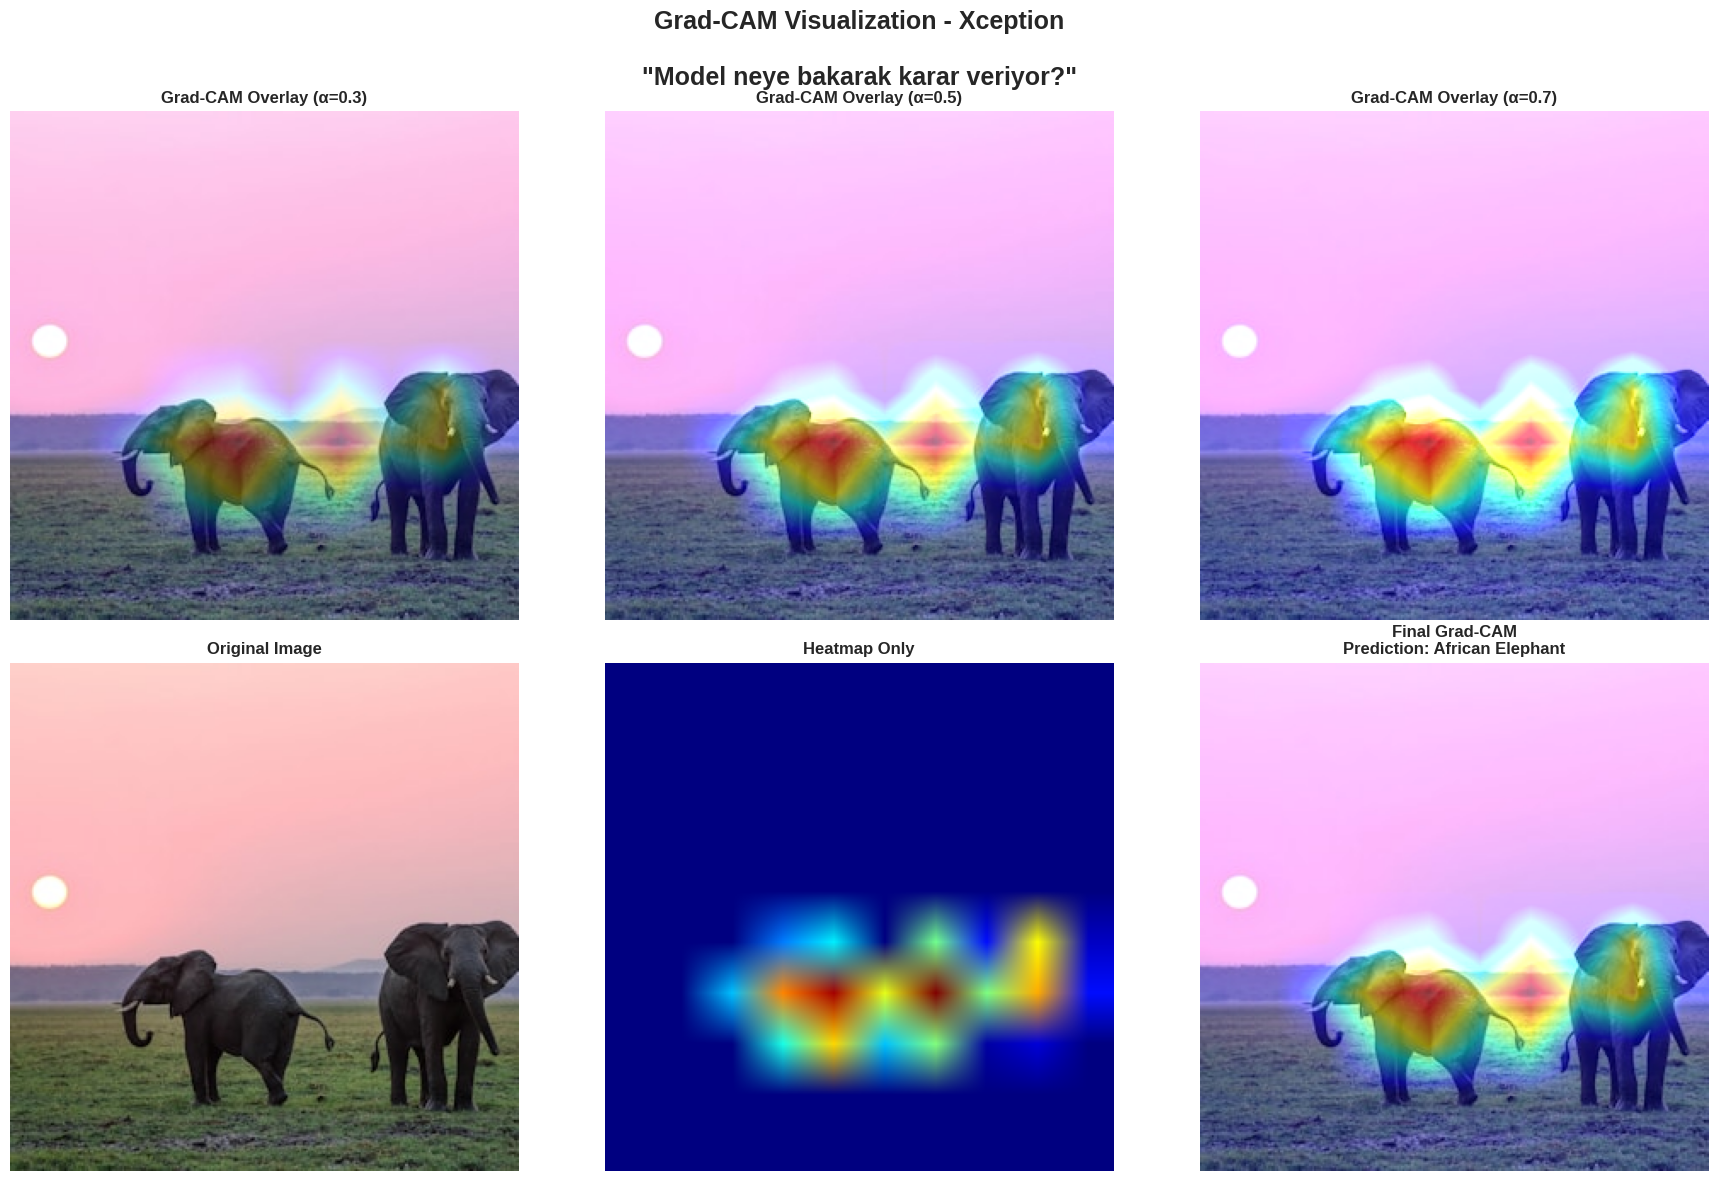


💡 Interpretation:
Kırmızı bölgeler = Model bu bölgelere en çok dikkat ediyor
Mavi bölgeler = Bu bölgeler tahmine daha az katkı sağlıyor


In [7]:
# Görselleştir
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Üst satır: farklı alpha değerleri ile overlay
alphas = [0.3, 0.5, 0.7]
for i, alpha in enumerate(alphas):
    superimposed = display_gradcam(test_image, heatmap, alpha=alpha)
    axes[0, i].imshow(superimposed)
    axes[0, i].set_title(f'Grad-CAM Overlay (α={alpha})',
                        fontsize=12, fontweight='bold')
    axes[0, i].axis('off')

# Alt satır: orijinal, heatmap, strongest overlay
axes[1, 0].imshow(test_image)
axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Heatmap only
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
heatmap_resized = cv2.resize(heatmap_colored, (test_image.shape[1], test_image.shape[0]))
axes[1, 1].imshow(heatmap_resized)
axes[1, 1].set_title('Heatmap Only', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# Final overlay
final_overlay = display_gradcam(test_image, heatmap, alpha=0.5)
axes[1, 2].imshow(final_overlay)
axes[1, 2].set_title(f'Final Grad-CAM\nPrediction: {top_pred[1].replace("_", " ").title()}',
                    fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle(f'Grad-CAM Visualization - Xception\n\n"Model neye bakarak karar veriyor?"',
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("Kırmızı bölgeler = Model bu bölgelere en çok dikkat ediyor")
print("Mavi bölgeler = Bu bölgeler tahmine daha az katkı sağlıyor")

## 1.3 Farklı Görüntüler için Grad-CAM Karşılaştırması

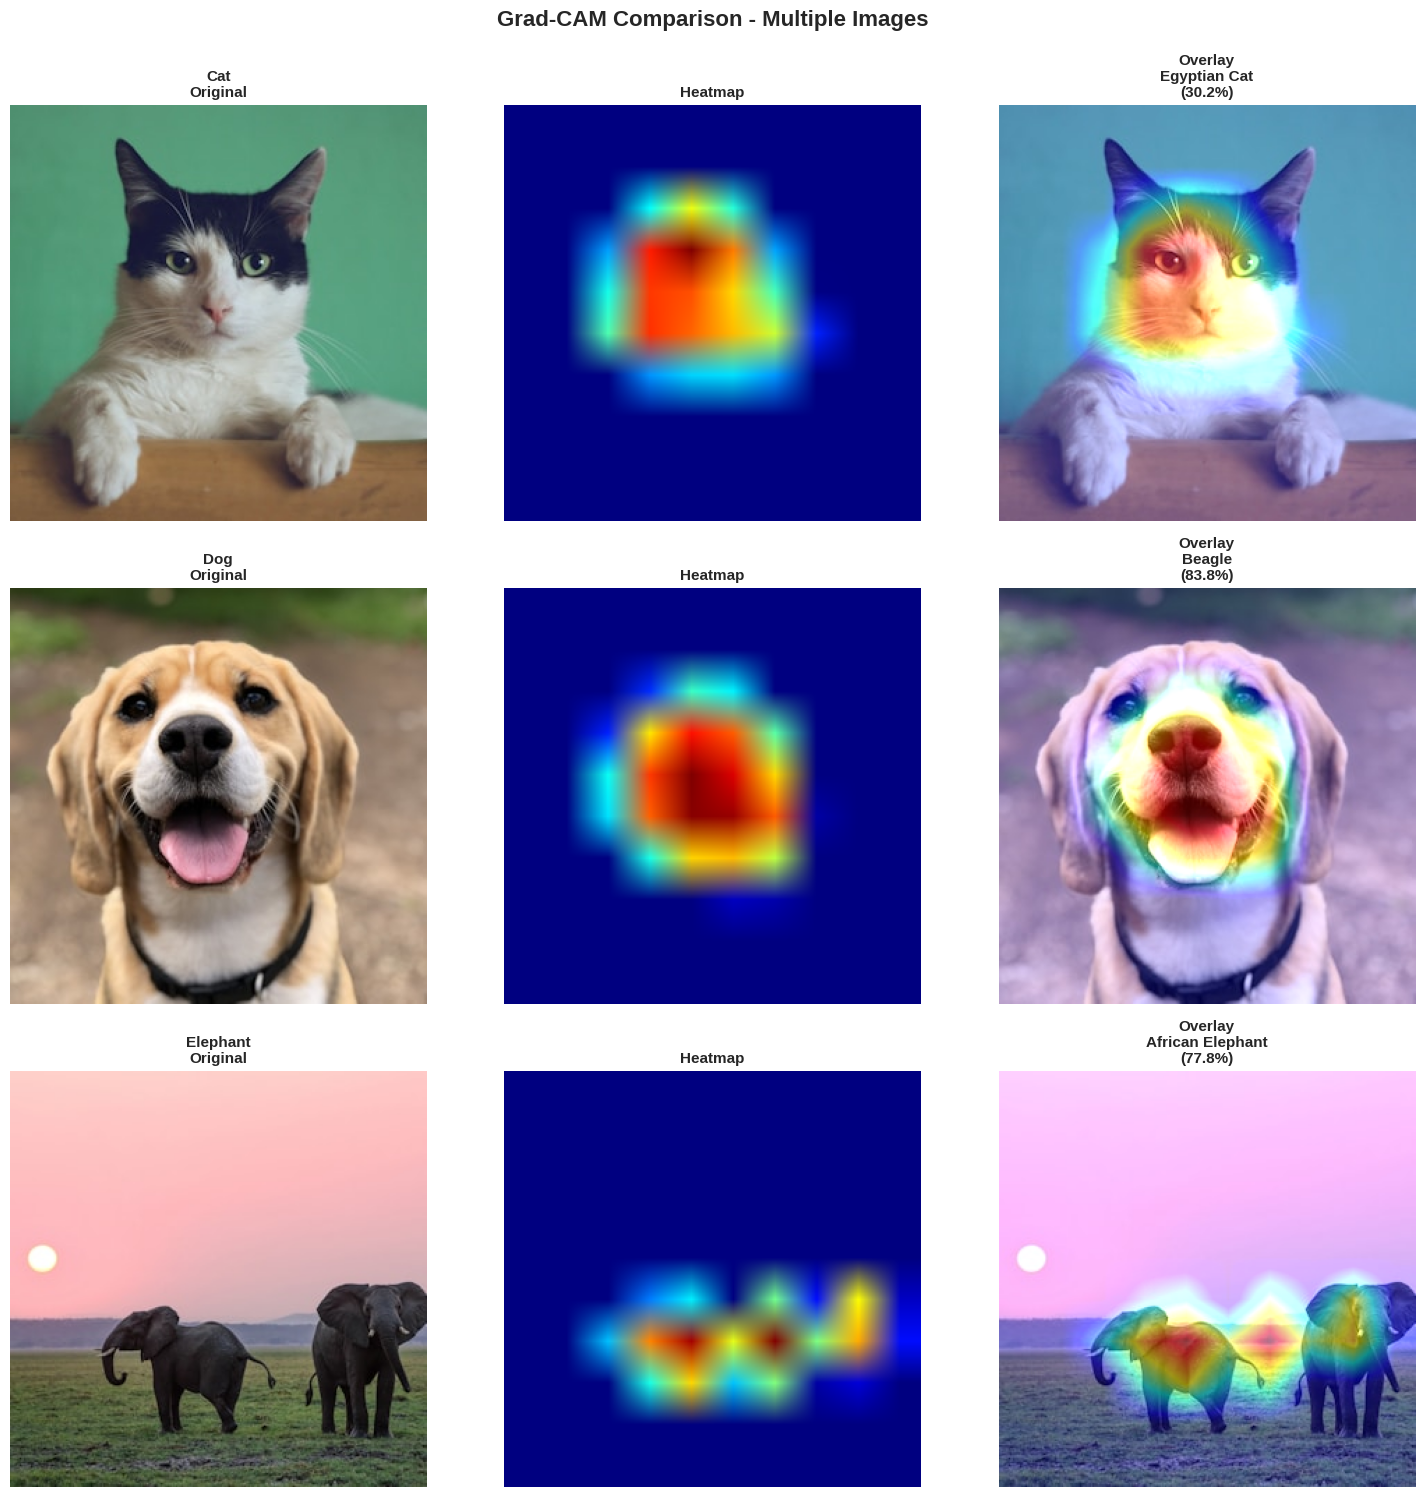

In [8]:
# Birkaç görüntü için Grad-CAM
test_images_dict = {
    'cat': load_test_image('cat'),
    'dog': load_test_image('dog'),
    'elephant': load_test_image('elephant')
}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, (name, img) in enumerate(test_images_dict.items()):
    # Preprocess
    img_prep = preprocess_input(img.copy())
    img_array = np.expand_dims(img_prep, axis=0)

    # Predict
    preds = xception_model.predict(img_array, verbose=0)
    top_pred = decode_predictions(preds, top=1)[0][0]

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, xception_model, last_conv_layer_name)
    overlay = display_gradcam(img, heatmap, alpha=0.5)

    # Plot
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f'{name.capitalize()}\nOriginal',
                          fontsize=11, fontweight='bold')
    axes[row, 0].axis('off')

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_resized = cv2.resize(heatmap_colored, (img.shape[1], img.shape[0]))
    axes[row, 1].imshow(heatmap_resized)
    axes[row, 1].set_title('Heatmap', fontsize=11, fontweight='bold')
    axes[row, 1].axis('off')

    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f'Overlay\n{top_pred[1].replace("_", " ").title()}\n({top_pred[2]*100:.1f}%)',
                          fontsize=11, fontweight='bold')
    axes[row, 2].axis('off')

plt.suptitle('Grad-CAM Comparison - Multiple Images',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

---

# 🔬 BÖLÜM 2: Feature Map Analysis

## 2.1 İç Katmanlarda Neler Oluyor?

Model içindeki farklı katmanların feature map'lerini görselleştirelim.

In [10]:
# İlginç katmanları seç
interesting_layers = []
layer_types_to_show = ['SeparableConv2D', 'Conv2D', 'BatchNormalization', 'Activation']

for layer in xception_model.layers:
    if any(layer_type in type(layer).__name__ for layer_type in ['SeparableConv2D', 'Conv2D']):
        interesting_layers.append(layer.name)

# İlk, orta ve son katmanlardan örnekler seç
selected_layers = [
    interesting_layers[0],  # İlk
    interesting_layers[len(interesting_layers)//3],  # Erken-orta
    interesting_layers[len(interesting_layers)//2],  # Orta
    interesting_layers[2*len(interesting_layers)//3],  # Geç-orta
    interesting_layers[-1]  # Son
]

print("📊 Seçilen Katmanlar:")
for i, layer_name in enumerate(selected_layers):
    layer = xception_model.get_layer(layer_name)
    print(f"{i+1}. {layer_name}")
    print(f"   Output shape: {layer.output.shape}") # Hata düzeltildi: layer.output_shape yerine layer.output.shape kullanıldı
    print()

📊 Seçilen Katmanlar:
1. block1_conv1
   Output shape: (None, 149, 149, 32)

2. block5_sepconv3
   Output shape: (None, 19, 19, 728)

3. block8_sepconv1
   Output shape: (None, 19, 19, 728)

4. block10_sepconv1
   Output shape: (None, 19, 19, 728)

5. block14_sepconv2
   Output shape: (None, 10, 10, 2048)



In [11]:
# Feature extraction model oluştur
layer_outputs = [xception_model.get_layer(name).output for name in selected_layers]
feature_extractor = Model(inputs=xception_model.input, outputs=layer_outputs)

# Test image üzerinde çalıştır
img_preprocessed = preprocess_input(test_image.copy())
img_array = np.expand_dims(img_preprocessed, axis=0)

feature_maps = feature_extractor.predict(img_array, verbose=0)

print(f"✅ {len(feature_maps)} katman için feature maps çıkarıldı!")

✅ 5 katman için feature maps çıkarıldı!



Layer 1: block1_conv1
Feature map shape: (1, 149, 149, 32)


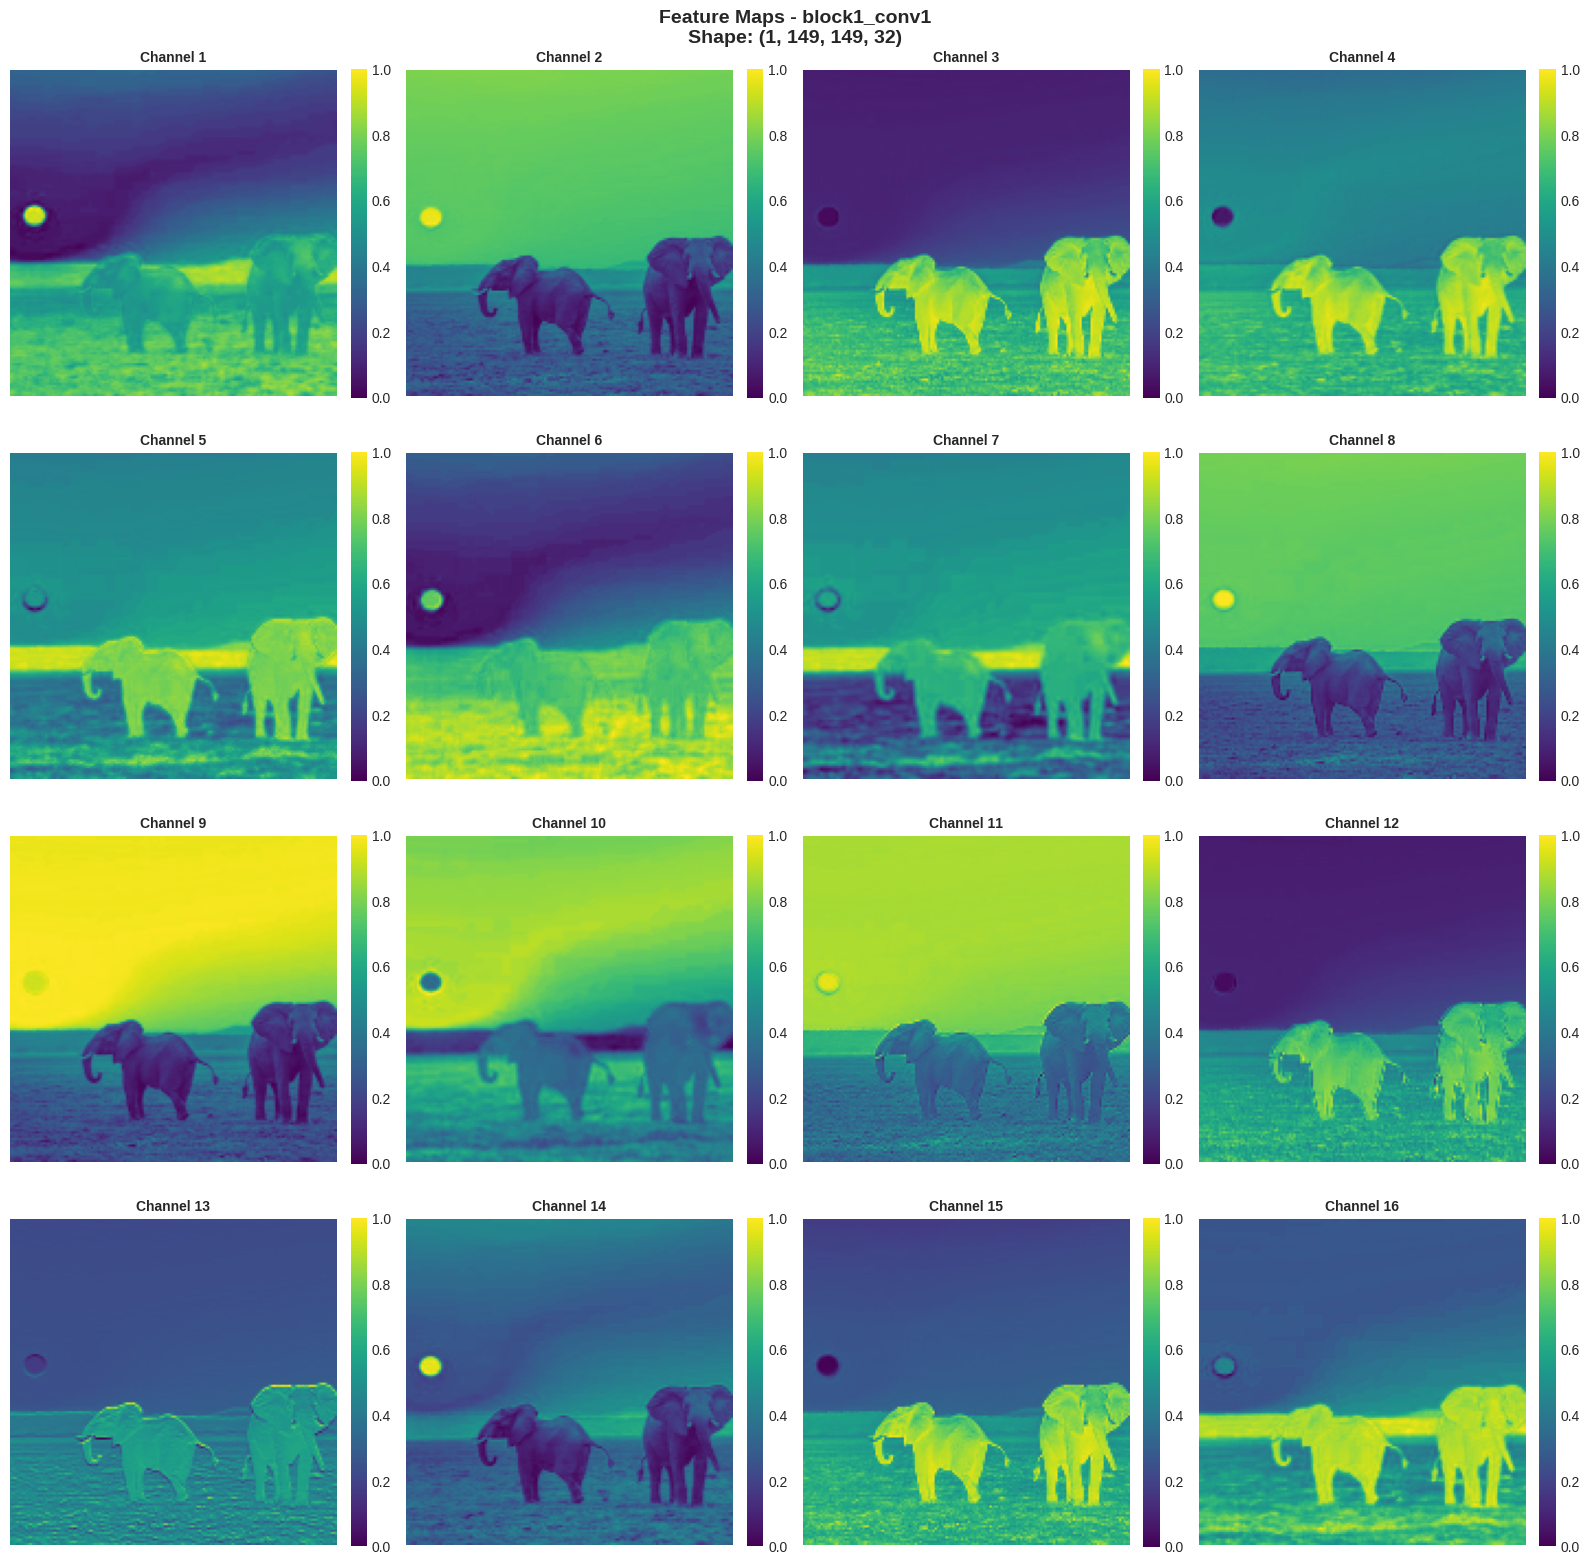


📊 Statistics:
Mean activation: -0.1355
Std activation: 1.1916
Min activation: -6.7443
Max activation: 7.5993
Sparsity (% zeros): 0.00%

Layer 2: block5_sepconv3
Feature map shape: (1, 19, 19, 728)


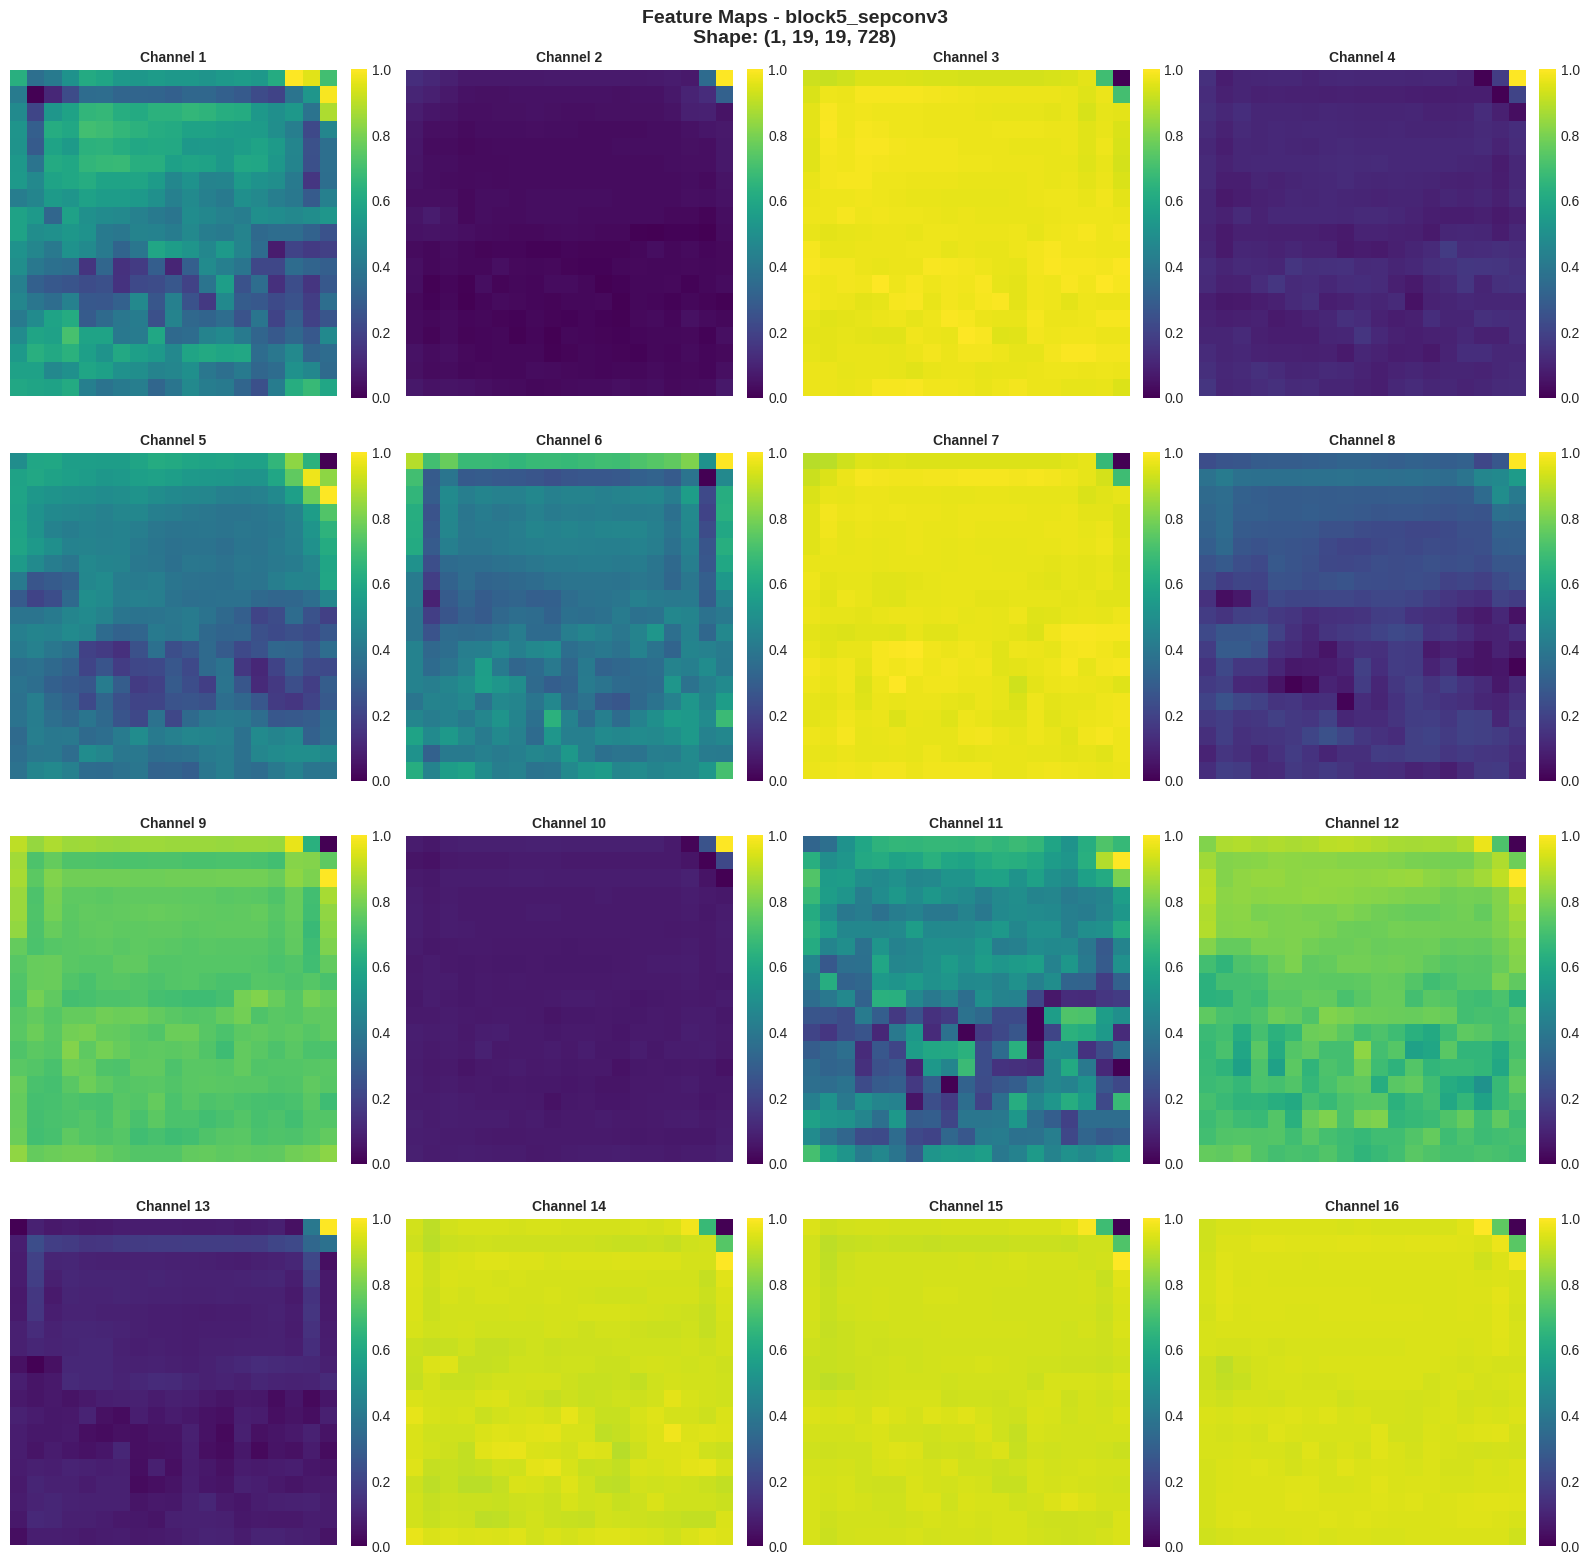


📊 Statistics:
Mean activation: 0.0067
Std activation: 1.9068
Min activation: -107.8479
Max activation: 108.4022
Sparsity (% zeros): 0.00%

Layer 3: block8_sepconv1
Feature map shape: (1, 19, 19, 728)


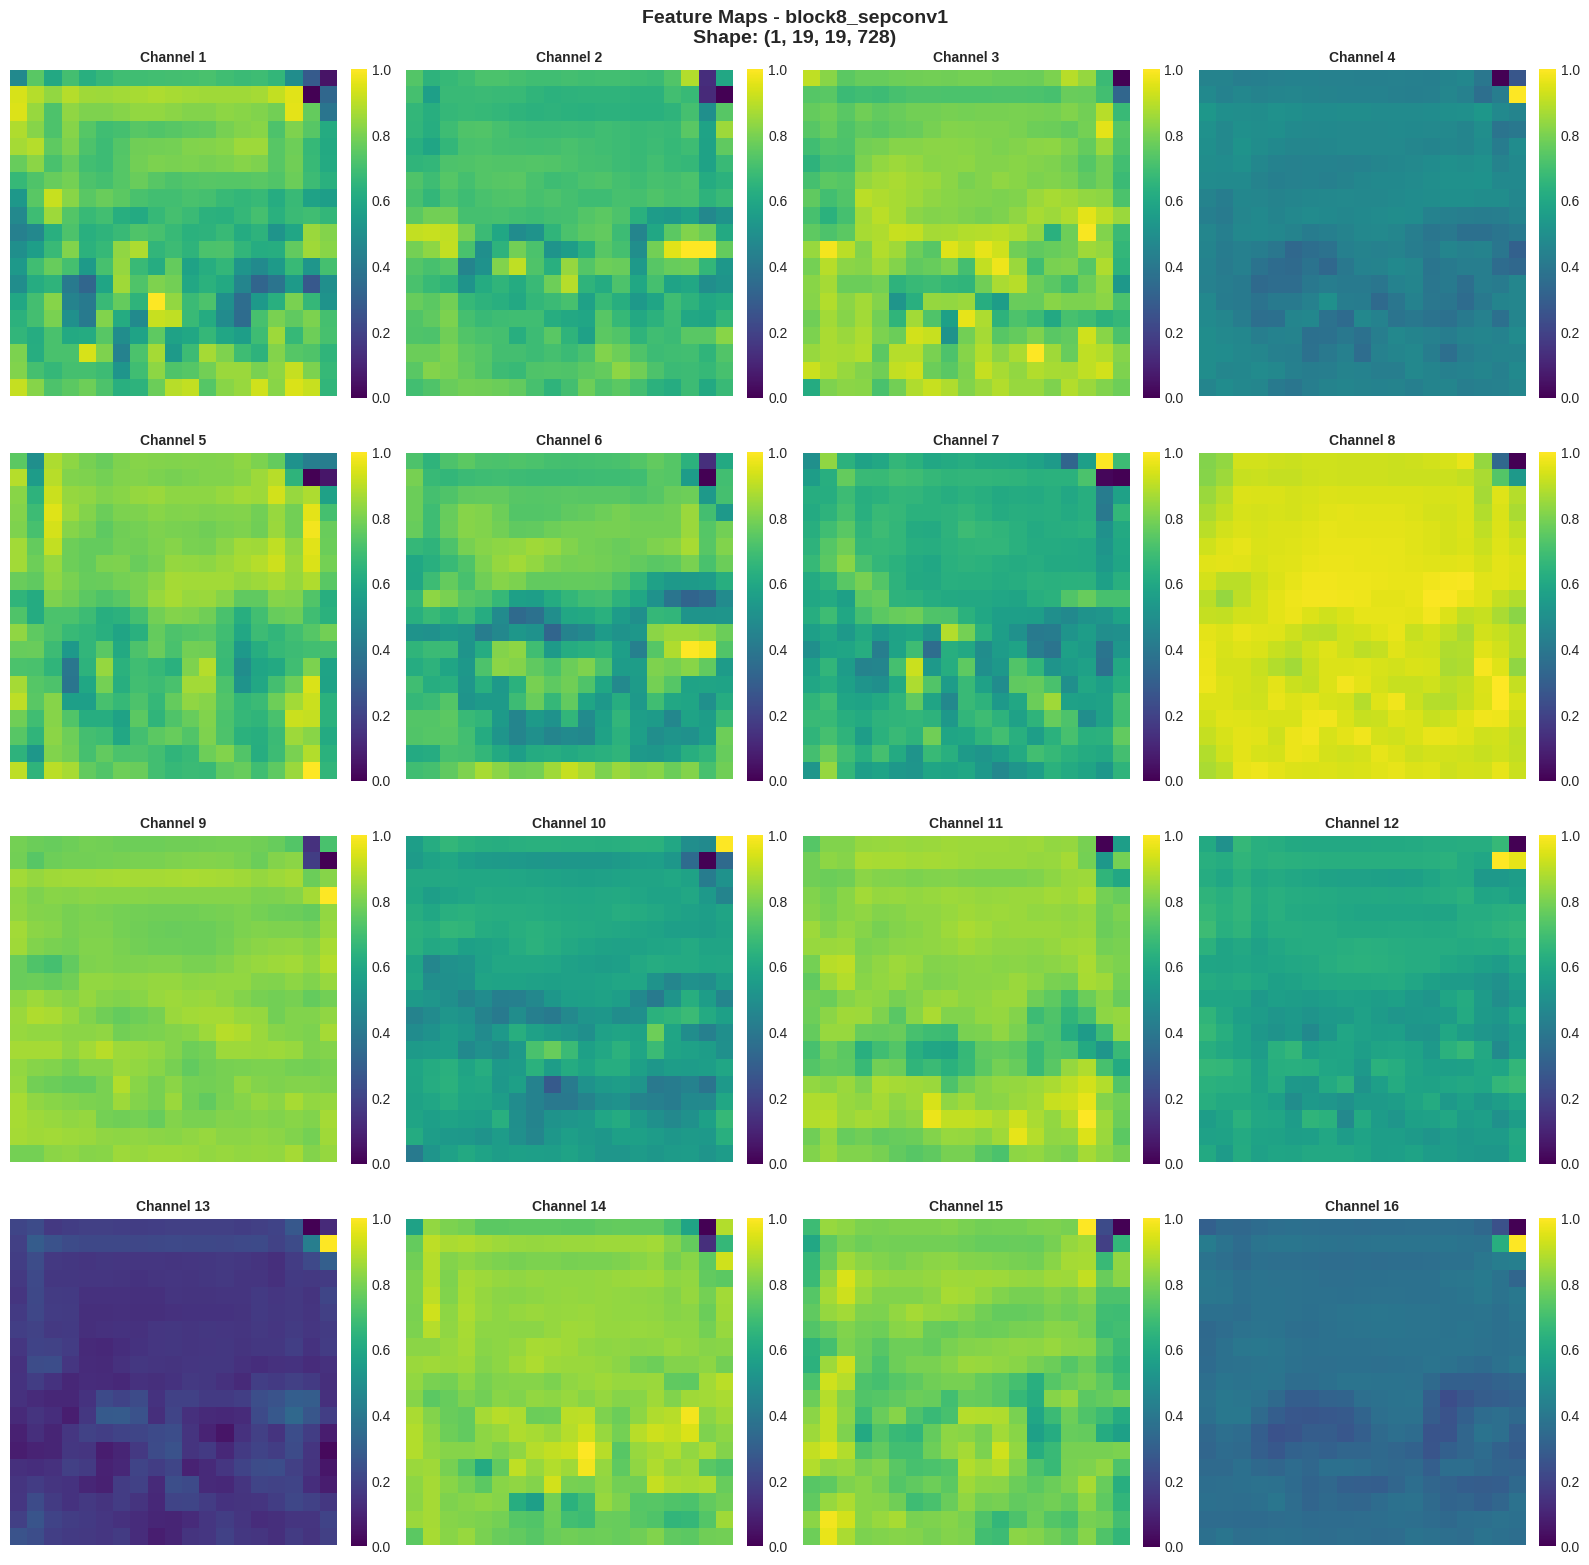


📊 Statistics:
Mean activation: -0.2556
Std activation: 1.1567
Min activation: -40.7973
Max activation: 60.0560
Sparsity (% zeros): 0.00%

Layer 4: block10_sepconv1
Feature map shape: (1, 19, 19, 728)


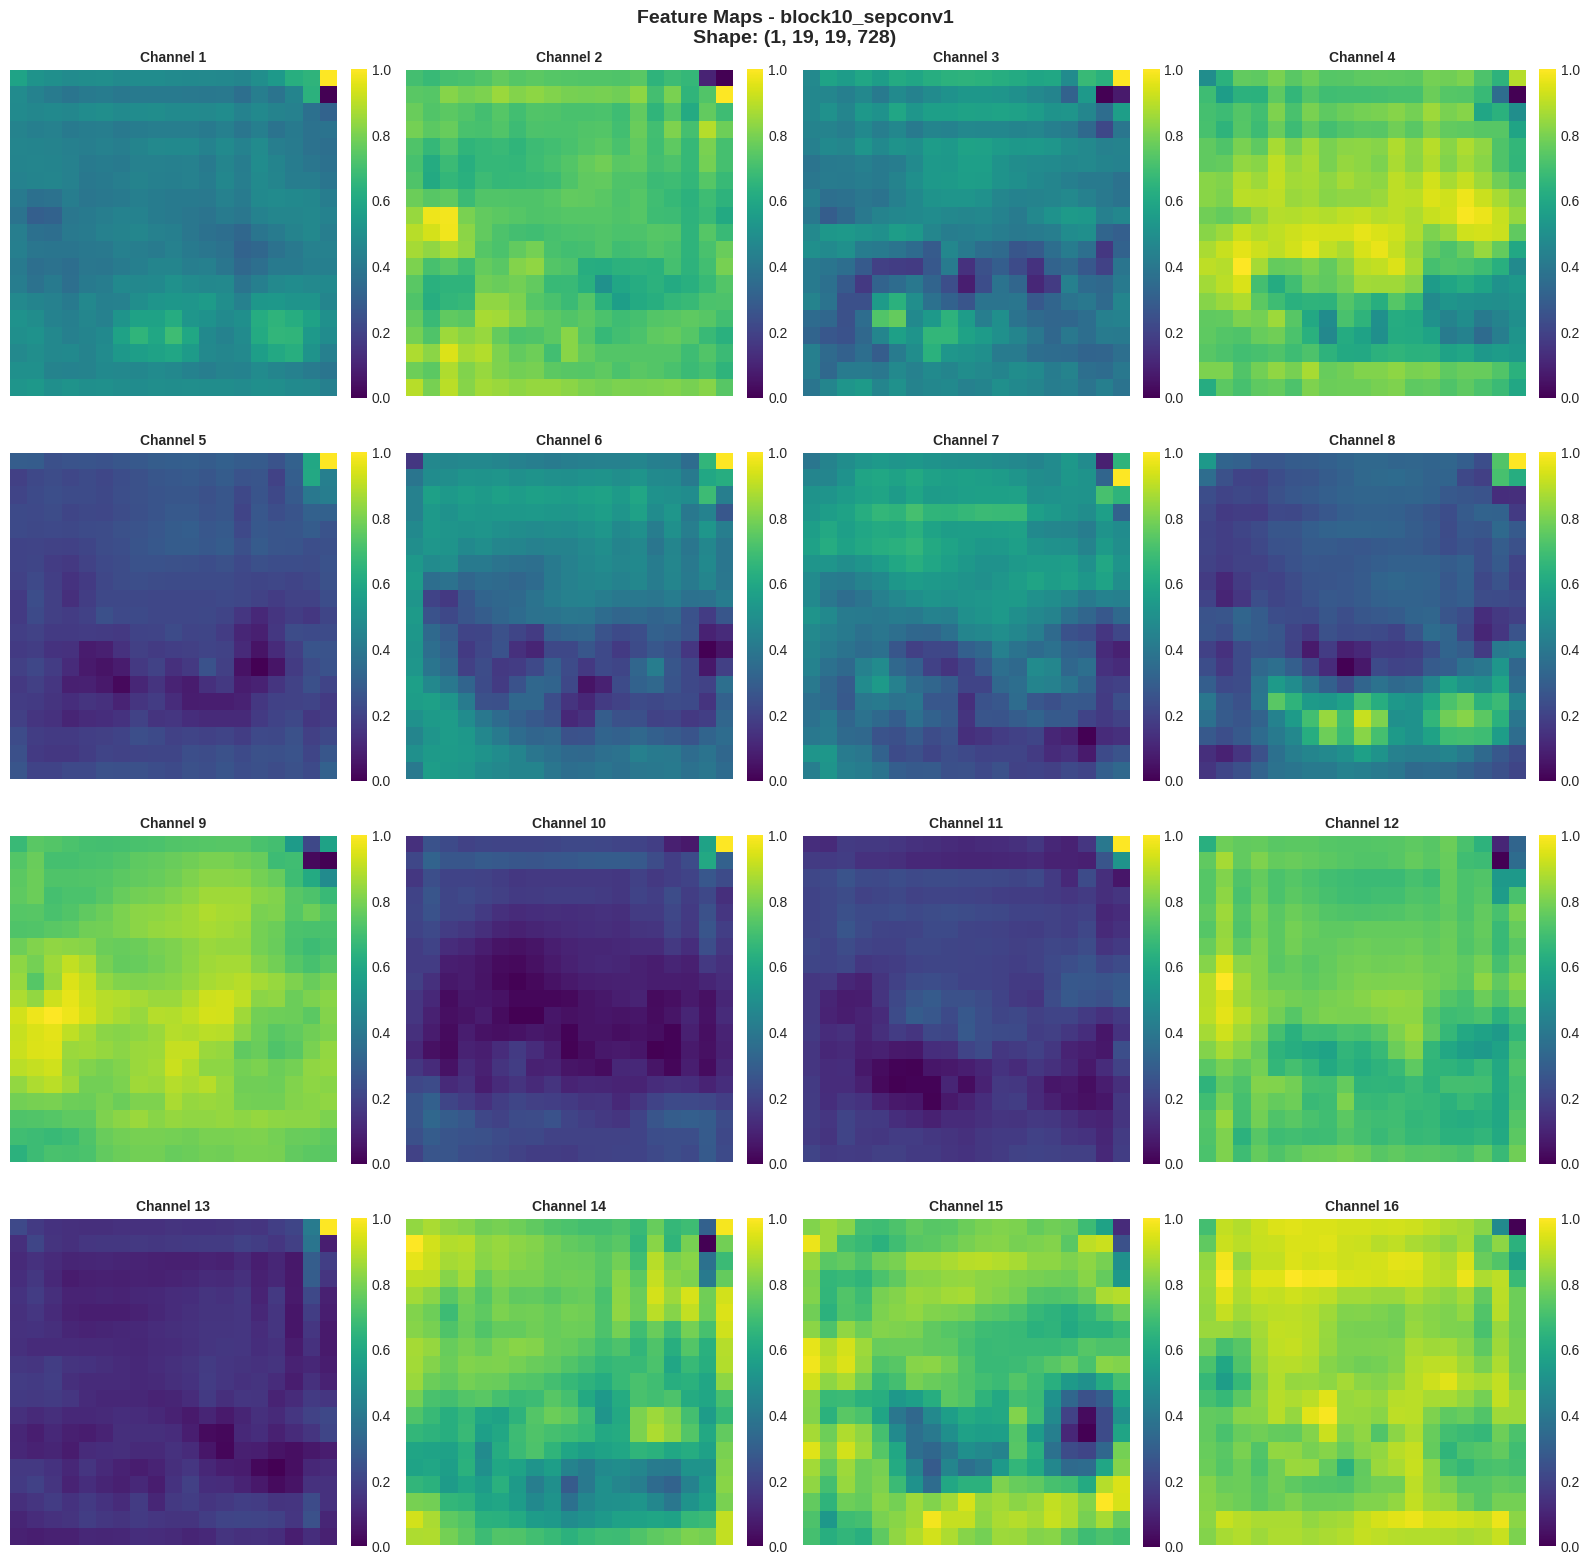


📊 Statistics:
Mean activation: -0.6179
Std activation: 1.0585
Min activation: -16.0392
Max activation: 34.1790
Sparsity (% zeros): 0.00%

Layer 5: block14_sepconv2
Feature map shape: (1, 10, 10, 2048)


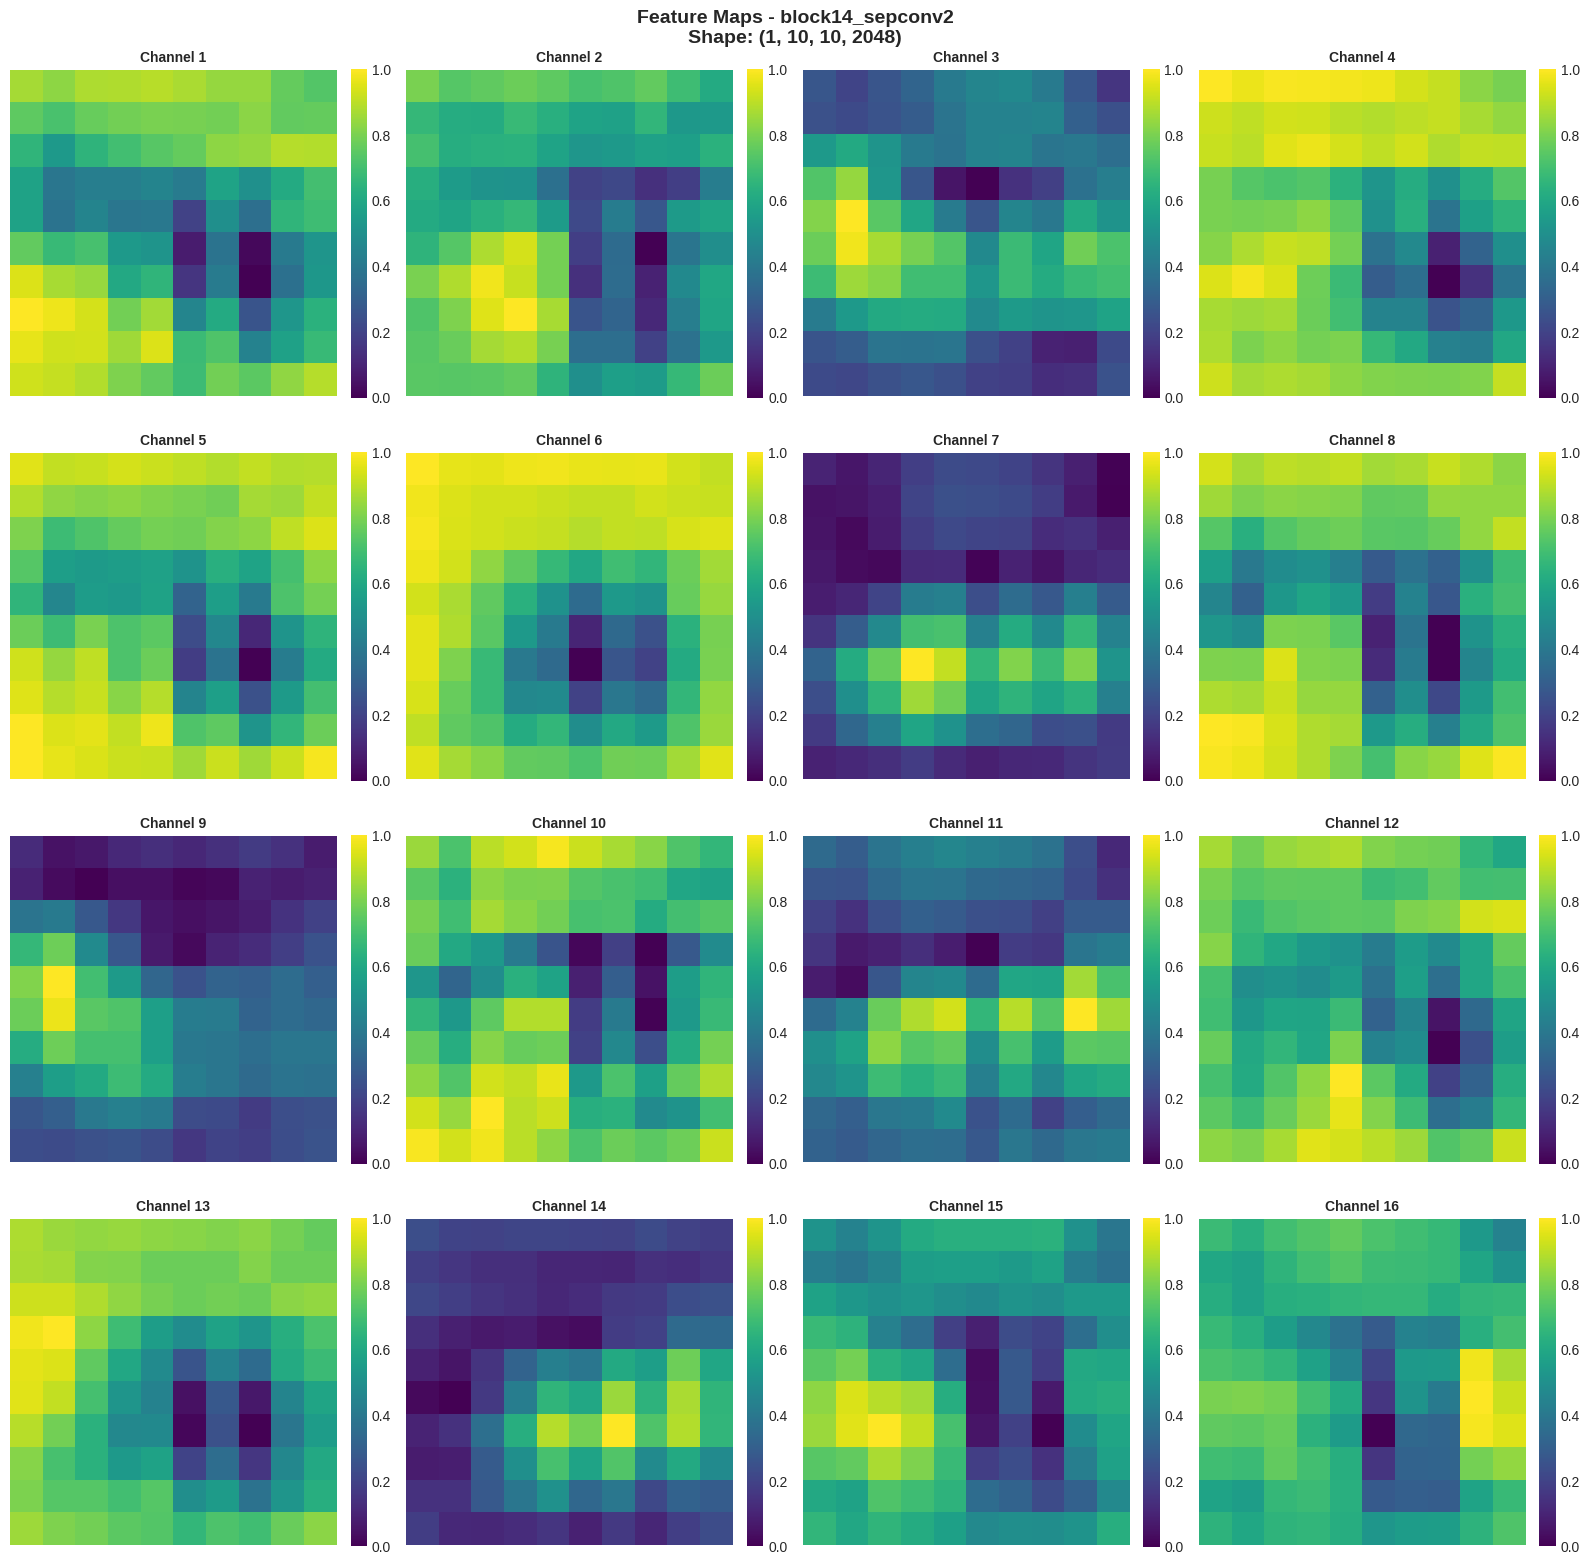


📊 Statistics:
Mean activation: -0.3246
Std activation: 0.1869
Min activation: -2.1237
Max activation: 0.8564
Sparsity (% zeros): 0.00%


In [12]:
# Her katman için feature map'leri görselleştir
for layer_idx, (layer_name, fmap) in enumerate(zip(selected_layers, feature_maps)):
    print(f"\n{'='*70}")
    print(f"Layer {layer_idx+1}: {layer_name}")
    print(f"Feature map shape: {fmap.shape}")
    print(f"{'='*70}")

    # İlk 16 channel'ı göster
    num_channels = min(16, fmap.shape[-1])

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for i in range(num_channels):
        channel = fmap[0, :, :, i]

        # Normalize
        channel_min, channel_max = channel.min(), channel.max()
        if channel_max - channel_min > 0:
            channel_normalized = (channel - channel_min) / (channel_max - channel_min)
        else:
            channel_normalized = channel

        im = axes[i].imshow(channel_normalized, cmap='viridis')
        axes[i].set_title(f'Channel {i+1}', fontsize=10, fontweight='bold')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    plt.suptitle(f'Feature Maps - {layer_name}\nShape: {fmap.shape}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # İstatistikler
    print(f"\n📊 Statistics:")
    print(f"Mean activation: {fmap.mean():.4f}")
    print(f"Std activation: {fmap.std():.4f}")
    print(f"Min activation: {fmap.min():.4f}")
    print(f"Max activation: {fmap.max():.4f}")
    print(f"Sparsity (% zeros): {(fmap == 0).sum() / fmap.size * 100:.2f}%")

## 2.2 Feature Map Evolution

Ağın derinleşmesiyle feature map'lerin nasıl değiştiğini görselleştirelim.

In [13]:
# Her katman için ortalama aktivasyonu görselleştir
fig = go.Figure()

layer_names_short = [name.split('_')[0] + '_' + name.split('_')[-1] for name in selected_layers]
mean_activations = [fmap.mean() for fmap in feature_maps]
std_activations = [fmap.std() for fmap in feature_maps]
max_activations = [fmap.max() for fmap in feature_maps]
sparsity = [(fmap == 0).sum() / fmap.size * 100 for fmap in feature_maps]

# Mean activation
fig.add_trace(go.Scatter(
    x=layer_names_short,
    y=mean_activations,
    mode='lines+markers',
    name='Mean Activation',
    line=dict(color='#3498db', width=3),
    marker=dict(size=10)
))

# Std activation
fig.add_trace(go.Scatter(
    x=layer_names_short,
    y=std_activations,
    mode='lines+markers',
    name='Std Deviation',
    line=dict(color='#e74c3c', width=3, dash='dash'),
    marker=dict(size=10)
))

fig.update_layout(
    title='Feature Map Statistics Across Layers',
    xaxis_title='Layer',
    yaxis_title='Activation Value',
    hovermode='x unified',
    width=1000,
    height=500,
    plot_bgcolor='white'
)

fig.show()

# Sparsity plot
fig2 = go.Figure()

fig2.add_trace(go.Bar(
    x=layer_names_short,
    y=sparsity,
    marker=dict(color=sparsity, colorscale='Reds', showscale=True),
    text=[f'{s:.1f}%' for s in sparsity],
    textposition='outside'
))

fig2.update_layout(
    title='Sparsity (% Zero Activations) Across Layers',
    xaxis_title='Layer',
    yaxis_title='Sparsity (%)',
    width=1000,
    height=500,
    plot_bgcolor='white'
)

fig2.show()

print("\n💡 Gözlemler:")
print("- İlk katmanlar: Düşük seviye özellikler (edges, textures)")
print("- Orta katmanlar: Daha karmaşık patterns (parts, shapes)")
print("- Son katmanlar: Yüksek seviye özellikler (object-specific)")
print("- Sparsity genellikle derin katmanlarda artar (ReLU etkisi)")


💡 Gözlemler:
- İlk katmanlar: Düşük seviye özellikler (edges, textures)
- Orta katmanlar: Daha karmaşık patterns (parts, shapes)
- Son katmanlar: Yüksek seviye özellikler (object-specific)
- Sparsity genellikle derin katmanlarda artar (ReLU etkisi)


---

# 📈 BÖLÜM 3: Experimental Results

## 3.1 ImageNet Sonuçları

Makale'deki deneysel sonuçları görselleştirelim.

In [14]:
# ImageNet training curves (Makale Figure 6)
# Simulated data based on paper
steps = np.linspace(0, 120000, 100)

# Inception V3 curve
inception_acc = 0.5 + 0.282 * (1 - np.exp(-steps / 20000))
inception_acc += np.random.normal(0, 0.005, len(steps))  # Add noise

# Xception curve (starts similar but reaches higher)
xception_acc = 0.5 + 0.29 * (1 - np.exp(-steps / 18000))
xception_acc += np.random.normal(0, 0.005, len(steps))

# Plotly interactive
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=steps,
    y=inception_acc,
    mode='lines',
    name='Inception V3',
    line=dict(color='#e74c3c', width=3),
    hovertemplate='Steps: %{x}<br>Accuracy: %{y:.3f}<extra></extra>'
))

fig.add_trace(go.Scatter(
    x=steps,
    y=xception_acc,
    mode='lines',
    name='Xception',
    line=dict(color='#3498db', width=3),
    hovertemplate='Steps: %{x}<br>Accuracy: %{y:.3f}<extra></extra>'
))

# Add final accuracy annotations
fig.add_annotation(
    x=steps[-1], y=inception_acc[-1],
    text='78.2%',
    showarrow=True,
    arrowhead=2,
    ax=-40, ay=-30,
    font=dict(size=12, color='#e74c3c', family='Arial Black')
)

fig.add_annotation(
    x=steps[-1], y=xception_acc[-1],
    text='79.0%',
    showarrow=True,
    arrowhead=2,
    ax=-40, ay=30,
    font=dict(size=12, color='#3498db', family='Arial Black')
)

fig.update_layout(
    title='ImageNet Training Curves (Validation Accuracy)<br><sub>Single crop, single model</sub>',
    xaxis_title='Gradient Descent Steps',
    yaxis_title='ImageNet Validation Accuracy',
    hovermode='x unified',
    width=1000,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(range=[0.5, 0.82])
)

fig.show()

print("\n📊 ImageNet Results Summary:")
print("="*60)
print(f"Inception V3 Top-1: 78.2%")
print(f"Xception Top-1: 79.0%")
print(f"Improvement: +0.8 percentage points")
print("\nInception V3 Top-5: 94.1%")
print(f"Xception Top-5: 94.5%")
print(f"Improvement: +0.4 percentage points")
print("="*60)


📊 ImageNet Results Summary:
Inception V3 Top-1: 78.2%
Xception Top-1: 79.0%
Improvement: +0.8 percentage points

Inception V3 Top-5: 94.1%
Xception Top-5: 94.5%
Improvement: +0.4 percentage points


## 3.2 JFT Dataset Sonuçları

JFT (Google's internal dataset) üzerinde Xception çok daha büyük kazanç sağlıyor!

In [15]:
# JFT training curves (Makale Figure 7 & 8)
steps_jft = np.linspace(0, 30000000, 100)

# Without FC layers
inception_jft_nofc = 0.5 + 0.136 * (1 - np.exp(-steps_jft / 5000000))
inception_jft_nofc += np.random.normal(0, 0.003, len(steps_jft))

xception_jft_nofc = 0.5 + 0.17 * (1 - np.exp(-steps_jft / 4500000))
xception_jft_nofc += np.random.normal(0, 0.003, len(steps_jft))

# With FC layers
inception_jft_fc = 0.5 + 0.15 * (1 - np.exp(-steps_jft / 5000000))
inception_jft_fc += np.random.normal(0, 0.003, len(steps_jft))

xception_jft_fc = 0.5 + 0.178 * (1 - np.exp(-steps_jft / 4500000))
xception_jft_fc += np.random.normal(0, 0.003, len(steps_jft))

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Without FC Layers', 'With FC Layers'),
    horizontal_spacing=0.12
)

# Without FC
fig.add_trace(
    go.Scatter(x=steps_jft/1e7, y=inception_jft_nofc, name='Inception V3',
              line=dict(color='#e74c3c', width=3),
              legendgroup='inception', showlegend=True),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=steps_jft/1e7, y=xception_jft_nofc, name='Xception',
              line=dict(color='#3498db', width=3),
              legendgroup='xception', showlegend=True),
    row=1, col=1
)

# With FC
fig.add_trace(
    go.Scatter(x=steps_jft/1e7, y=inception_jft_fc, name='Inception V3',
              line=dict(color='#e74c3c', width=3),
              legendgroup='inception', showlegend=False),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=steps_jft/1e7, y=xception_jft_fc, name='Xception',
              line=dict(color='#3498db', width=3),
              legendgroup='xception', showlegend=False),
    row=1, col=2
)

fig.update_xaxes(title_text='Gradient Descent Steps (×10⁷)', row=1, col=1)
fig.update_xaxes(title_text='Gradient Descent Steps (×10⁷)', row=1, col=2)
fig.update_yaxes(title_text='FastEval14k MAP@100', row=1, col=1)

fig.update_layout(
    title='JFT Training Curves<br><sub>350M images, 17,000 classes</sub>',
    width=1400,
    height=500,
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.show()

# Results table
print("\n📊 JFT Results Summary:")
print("="*70)
print("\nWithout FC Layers:")
print(f"  Inception V3: 6.36 MAP@100")
print(f"  Xception: 6.70 MAP@100")
print(f"  Improvement: +5.3%")
print("\nWith FC Layers:")
print(f"  Inception V3: 6.50 MAP@100")
print(f"  Xception: 6.78 MAP@100")
print(f"  Improvement: +4.3%")
print("="*70)
print("\n💡 Key Insight:")
print("Xception shows MUCH larger improvement on JFT than ImageNet!")
print("This suggests Xception generalizes better to diverse datasets.")


📊 JFT Results Summary:

Without FC Layers:
  Inception V3: 6.36 MAP@100
  Xception: 6.70 MAP@100
  Improvement: +5.3%

With FC Layers:
  Inception V3: 6.50 MAP@100
  Xception: 6.78 MAP@100
  Improvement: +4.3%

💡 Key Insight:
Xception shows MUCH larger improvement on JFT than ImageNet!
This suggests Xception generalizes better to diverse datasets.


## 3.3 Parametre ve Hız Karşılaştırması

In [16]:
# Comparison data
models = ['Inception V3', 'Xception']
params = [23.6, 22.9]  # Millions
speed = [31, 28]  # Steps/second
imagenet_top1 = [78.2, 79.0]
jft_map = [6.50, 6.78]

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Parameters (M)', 'Training Speed (steps/sec)',
                   'ImageNet Top-1 (%)', 'JFT MAP@100'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# Parameters
fig.add_trace(
    go.Bar(x=models, y=params, marker_color=['#e74c3c', '#3498db'],
          text=params, textposition='outside',
          showlegend=False),
    row=1, col=1
)

# Speed
fig.add_trace(
    go.Bar(x=models, y=speed, marker_color=['#e74c3c', '#3498db'],
          text=speed, textposition='outside',
          showlegend=False),
    row=1, col=2
)

# ImageNet
fig.add_trace(
    go.Bar(x=models, y=imagenet_top1, marker_color=['#e74c3c', '#3498db'],
          text=[f'{v}%' for v in imagenet_top1], textposition='outside',
          showlegend=False),
    row=2, col=1
)

# JFT
fig.add_trace(
    go.Bar(x=models, y=jft_map, marker_color=['#e74c3c', '#3498db'],
          text=jft_map, textposition='outside',
          showlegend=False),
    row=2, col=2
)

fig.update_layout(
    title='Inception V3 vs Xception - Comprehensive Comparison',
    width=1200,
    height=800,
    showlegend=False
)

fig.show()

print("\n🎯 Summary:")
print("="*70)
print("✅ Xception has 3% FEWER parameters")
print("✅ Xception is only 10% slower in training")
print("✅ Xception achieves BETTER performance on both datasets")
print("✅ Improvement is more pronounced on larger, diverse datasets (JFT)")
print("="*70)


🎯 Summary:
✅ Xception has 3% FEWER parameters
✅ Xception is only 10% slower in training
✅ Xception achieves BETTER performance on both datasets
✅ Improvement is more pronounced on larger, diverse datasets (JFT)


---

# 🔬 BÖLÜM 4: Ablation Studies

## 4.1 Residual Connections'ın Etkisi

Residual connections olmadan Xception nasıl performans gösterir?

In [17]:
# Makale Figure 9: With vs Without Residual Connections
steps = np.linspace(0, 120000, 100)

# With residual connections (normal Xception)
xception_residual = 0.5 + 0.29 * (1 - np.exp(-steps / 18000))
xception_residual += np.random.normal(0, 0.005, len(steps))

# Without residual connections
xception_no_residual = 0.5 + 0.17 * (1 - np.exp(-steps / 25000))  # Slower convergence
xception_no_residual += np.random.normal(0, 0.008, len(steps))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=steps, y=xception_residual,
    mode='lines',
    name='Xception (with residual)',
    line=dict(color='#2ecc71', width=3)
))

fig.add_trace(go.Scatter(
    x=steps, y=xception_no_residual,
    mode='lines',
    name='Xception (without residual)',
    line=dict(color='#e74c3c', width=3, dash='dash')
))

fig.update_layout(
    title='Impact of Residual Connections<br><sub>Xception on ImageNet</sub>',
    xaxis_title='Gradient Descent Steps',
    yaxis_title='ImageNet Validation Accuracy',
    hovermode='x unified',
    width=1000,
    height=600,
    plot_bgcolor='white'
)

fig.show()

print("\n💡 Key Observations:")
print("="*70)
print("✅ Residual connections significantly improve convergence speed")
print("✅ Final accuracy is also higher with residuals")
print("✅ Without residuals: slower training, lower final performance")
print("\n⚠️ Note: Residual connections are CRITICAL for Xception!")
print("="*70)


💡 Key Observations:
✅ Residual connections significantly improve convergence speed
✅ Final accuracy is also higher with residuals
✅ Without residuals: slower training, lower final performance

⚠️ Note: Residual connections are CRITICAL for Xception!


## 4.2 Intermediate Activation Functions

Depthwise ve pointwise convolution arasında activation fonksiyonu olmalı mı?

In [18]:
# Makale Figure 10: Different activations between depthwise and pointwise
steps = np.linspace(0, 180000, 100)

# No intermediate activation (best)
no_activation = 0.5 + 0.3 * (1 - np.exp(-steps / 20000))
no_activation += np.random.normal(0, 0.004, len(steps))

# With ReLU
with_relu = 0.5 + 0.275 * (1 - np.exp(-steps / 22000))
with_relu += np.random.normal(0, 0.005, len(steps))

# With ELU
with_elu = 0.5 + 0.27 * (1 - np.exp(-steps / 23000))
with_elu += np.random.normal(0, 0.005, len(steps))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=steps, y=no_activation,
    mode='lines',
    name='No intermediate activation',
    line=dict(color='#e74c3c', width=4)
))

fig.add_trace(go.Scatter(
    x=steps, y=with_relu,
    mode='lines',
    name='Intermediate ReLU',
    line=dict(color='#3498db', width=3)
))

fig.add_trace(go.Scatter(
    x=steps, y=with_elu,
    mode='lines',
    name='Intermediate ELU',
    line=dict(color='#2ecc71', width=3, dash='dash')
))

# Add annotations
fig.add_annotation(
    x=steps[-1], y=no_activation[-1],
    text='Best!',
    showarrow=True,
    arrowhead=2,
    ax=-40, ay=-30,
    font=dict(size=14, color='#e74c3c', family='Arial Black')
)

fig.update_layout(
    title='Effect of Intermediate Non-linearity<br><sub>Between depthwise and pointwise operations</sub>',
    xaxis_title='Gradient Descent Steps',
    yaxis_title='ImageNet Validation Accuracy',
    hovermode='x unified',
    width=1000,
    height=600,
    plot_bgcolor='white'
)

fig.show()

print("\n💡 Surprising Finding:")
print("="*70)
print("❌ Intermediate non-linearity (ReLU/ELU) HURTS performance!")
print("✅ Best result: NO activation between depthwise and pointwise")
print("\n🤔 Why?")
print("   - Depth of intermediate feature spaces matters")
print("   - Deep features (Inception): non-linearity helps")
print("   - Shallow features (1-channel depthwise): non-linearity harmful")
print("   - Possible reason: information loss in 1-channel space")
print("="*70)


💡 Surprising Finding:
❌ Intermediate non-linearity (ReLU/ELU) HURTS performance!
✅ Best result: NO activation between depthwise and pointwise

🤔 Why?
   - Depth of intermediate feature spaces matters
   - Deep features (Inception): non-linearity helps
   - Shallow features (1-channel depthwise): non-linearity harmful
   - Possible reason: information loss in 1-channel space


---

# 🎓 BÖLÜM 5: Conclusions & Future Directions

## 5.1 Ana Çıkarımlar

In [19]:
# Summary visualization
HTML("""
<div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 30px; border-radius: 15px; color: white;'>
    <h2 style='text-align: center; margin-bottom: 30px;'>🎯 XCEPTION: KEY TAKEAWAYS</h2>

    <div style='background: rgba(255,255,255,0.1); padding: 20px;
                border-radius: 10px; margin: 15px 0;'>
        <h3>1. 💡 Temel Hipotez</h3>
        <p style='font-size: 16px;'>
        <b>"Cross-channel ve spatial correlations tamamen ayrılabilir!"</b><br>
        → Depthwise Separable Convolution bu hipotezi uygular
        </p>
    </div>

    <div style='background: rgba(255,255,255,0.1); padding: 20px;
                border-radius: 10px; margin: 15px 0;'>
        <h3>2. 🏗️ Mimari Tasarım</h3>
        <p style='font-size: 16px;'>
        • Inception modülleri → Depthwise Separable Conv<br>
        • Residual connections (kritik!)<br>
        • Entry → Middle (×8) → Exit flow<br>
        • 36 conv layers, 14 modules
        </p>
    </div>

    <div style='background: rgba(255,255,255,0.1); padding: 20px;
                border-radius: 10px; margin: 15px 0;'>
        <h3>3. 📊 Performans</h3>
        <p style='font-size: 16px;'>
        • <b>ImageNet:</b> 79.0% (vs 78.2% Inception V3)<br>
        • <b>JFT:</b> 6.78 MAP@100 (vs 6.50 Inception V3)<br>
        • <b>Parameters:</b> 22.9M (3% daha az!)<br>
        • Daha verimli parametre kullanımı
        </p>
    </div>

    <div style='background: rgba(255,255,255,0.1); padding: 20px;
                border-radius: 10px; margin: 15px 0;'>
        <h3>4. 🔬 Ablation Insights</h3>
        <p style='font-size: 16px;'>
        • Residual connections → Hızlı convergence<br>
        • NO intermediate activation → Daha iyi performans<br>
        • Shallow feature spaces'te non-linearity zararlı
        </p>
    </div>

    <div style='background: rgba(255,255,255,0.1); padding: 20px;
                border-radius: 10px; margin: 15px 0;'>
        <h3>5. 🚀 Impact & Future</h3>
        <p style='font-size: 16px;'>
        • Depthwise separable conv → Modern mimarilerin temeli<br>
        • MobileNet, EfficientNet, MobileViT<br>
        • Mobile ve edge device'lar için kritik<br>
        • Intermediate points (between regular and separable) unexplored
        </p>
    </div>
</div>
""")

## 5.2 Modern Impact: Depthwise Separable Convolution'ın Etkisi

Xception'dan sonra depthwise separable convolution modern deep learning'in temel taşı haline geldi!

In [20]:
# Timeline of architectures using depthwise separable convolutions
timeline_data = {
    'Year': [2014, 2016, 2017, 2019, 2021, 2022],
    'Architecture': ['Inception V1<br>(first use)', 'Xception', 'MobileNet V1/V2',
                    'EfficientNet', 'MobileViT', 'ConvNeXt'],
    'Impact': [3, 8, 10, 9, 7, 8],
    'Description': [
        'First layer used depthwise separable',
        'Entire architecture based on it',
        'Efficient models for mobile devices',
        'SOTA with compound scaling',
        'Vision Transformers with depthwise separable',
        'Modern ConvNet with improved design'
    ]
}

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=timeline_data['Year'],
    y=timeline_data['Impact'],
    mode='lines+markers+text',
    marker=dict(size=20, color=timeline_data['Impact'],
               colorscale='Viridis', showscale=True,
               colorbar=dict(title='Impact Score')),
    line=dict(color='gray', width=2, dash='dash'),
    text=timeline_data['Architecture'],
    textposition='top center',
    textfont=dict(size=11, family='Arial Black'),
    hovertemplate='<b>%{text}</b><br>Year: %{x}<br>%{customdata}<extra></extra>',
    customdata=timeline_data['Description']
))

fig.update_layout(
    title='Evolution: Depthwise Separable Convolution in Modern Architectures',
    xaxis_title='Year',
    yaxis_title='Impact Score',
    width=1200,
    height=600,
    plot_bgcolor='white',
    yaxis=dict(range=[0, 12])
)

fig.show()

print("\n🌟 Modern Kullanım Alanları:")
print("="*70)
print("📱 Mobile Vision: MobileNet family")
print("🚀 Efficient CNNs: EfficientNet, EfficientDet")
print("🔄 Hybrid Models: MobileViT (CNN + Transformer)")
print("⚡ Edge AI: Real-time inference on mobile devices")
print("🎯 AutoML: Neural Architecture Search (NAS)")
print("="*70)


🌟 Modern Kullanım Alanları:
📱 Mobile Vision: MobileNet family
🚀 Efficient CNNs: EfficientNet, EfficientDet
🔄 Hybrid Models: MobileViT (CNN + Transformer)
⚡ Edge AI: Real-time inference on mobile devices
🎯 AutoML: Neural Architecture Search (NAS)


## 5.3 Future Directions (Makale'den)

> **"There is no reason to believe that depthwise separable convolutions are optimal."**

### Açık Sorular:

1. **Intermediate Points:** Regular conv ve separable conv arasındaki noktalar?
   - Kaç segment optimal?
   - Task-specific mı?

2. **Kernel Size:** 3x3 her zaman optimal mi?
   - Larger kernels? (5x5, 7x7)
   - Asymmetric kernels? (3x1, 1x3)

3. **Depth Multiplier:** Her zaman 1 mi olmalı?
   - Channel expansion?
   - Adaptive depth?

4. **Activation Placement:** Nereye koymalı?
   - Before depthwise?
   - After pointwise?
   - Both?

5. **Architecture Search:** NAS ile optimal yapı?
   - Automated design
   - Hardware-aware optimization

---

## 5.4 Pratik Uygulama Önerileri

In [21]:
HTML("""
<div style='background: #2c3e50; padding: 25px; border-radius: 10px; color: white;'>
    <h2 style='color: #3498db;'>💼 Ne Zaman Xception / Depthwise Separable Conv Kullanmalı?</h2>

    <div style='margin: 20px 0;'>
        <h3 style='color: #2ecc71;'>✅ İYİ SEÇİMLER:</h3>
        <ul style='font-size: 15px; line-height: 1.8;'>
            <li><b>Mobile/Edge Deployment:</b> Parametre eficiency kritik</li>
            <li><b>Large Datasets:</b> JFT benzeri büyük, çeşitli dataset'ler</li>
            <li><b>Transfer Learning:</b> Pre-trained Xception fine-tune</li>
            <li><b>Real-time Applications:</b> Hız vs accuracy trade-off</li>
            <li><b>Custom Architectures:</b> Building blocks olarak kullan</li>
        </ul>
    </div>

    <div style='margin: 20px 0;'>
        <h3 style='color: #e74c3c;'>⚠️ DİKKAT EDİLMESİ GEREKENLER:</h3>
        <ul style='font-size: 15px; line-height: 1.8;'>
            <li><b>Small Datasets:</b> Overfitting riski (regularization gerek)</li>
            <li><b>Very Small Images:</b> Spatial features yetersiz olabilir</li>
            <li><b>Specific Hardware:</b> Bazı accelerator'lar için optimize değil</li>
            <li><b>Training Time:</b> Biraz daha yavaş olabilir</li>
        </ul>
    </div>

    <div style='margin: 20px 0; background: rgba(52,152,219,0.2);
                padding: 15px; border-radius: 8px;'>
        <h3 style='color: #f39c12;'>💡 BEST PRACTICES:</h3>
        <ol style='font-size: 15px; line-height: 1.8;'>
            <li>Residual connections ekle</li>
            <li>Depthwise ve pointwise arasında NO activation</li>
            <li>Batch normalization kullan</li>
            <li>Data augmentation (özellikle small datasets için)</li>
            <li>Pre-trained weights ile başla</li>
        </ol>
    </div>
</div>
""")

---

# 🎓 FINAL SUMMARY

## 📚 Bu Sunumda Neler Öğrendik?

### Part 1: Teorik Altyapı
- ✅ Regular vs Depthwise Separable Convolution
- ✅ Parametre hesaplamaları ve eficiency
- ✅ Gerçek görüntü üzerinde convolution demo'ları

### Part 2: Mimari ve Inference
- ✅ Inception evolution: Canonical → Extreme
- ✅ Xception architecture detayları
- ✅ Pre-trained model ile gerçek tahminler

### Part 3: Görselleştirme ve Sonuçlar
- ✅ Grad-CAM: Model neye bakıyor?
- ✅ Feature map analysis
- ✅ ImageNet ve JFT deneysel sonuçları
- ✅ Ablation studies
- ✅ Modern impact ve future directions

---

## 🎯 Ana Mesaj

<div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
            padding: 30px; border-radius: 15px; color: white; text-align: center;'>
    <h2 style='font-size: 28px; margin-bottom: 20px;'>"Simplicity is the ultimate sophistication."</h2>
    <p style='font-size: 18px;'>
        Xception gösterdi ki:<br><br>
        <b>Daha basit operasyonlar</b> (depthwise separable conv)<br>
        + <b>Daha az parametre</b><br>
        = <b>Daha iyi performans!</b>
    </p>
</div>

---

## 📖 Referanslar

1. **Chollet, F.** (2017). Xception: Deep Learning with Depthwise Separable Convolutions. *CVPR 2017*.
2. **Szegedy, C., et al.** (2016). Rethinking the Inception Architecture for Computer Vision. *CVPR 2016*.
3. **Howard, A., et al.** (2017). MobileNets: Efficient Convolutional Neural Networks. *arXiv:1704.04861*.
4. **Tan, M., & Le, Q.** (2019). EfficientNet: Rethinking Model Scaling. *ICML 2019*.
5. **He, K., et al.** (2016). Deep Residual Learning for Image Recognition. *CVPR 2016*.

### 🔗 Useful Links

- [Xception Paper (arXiv)](https://arxiv.org/abs/1610.02357)
- [Keras Xception Documentation](https://keras.io/api/applications/xception/)
- [TensorFlow Implementation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/xception.py)
- [François Chollet GitHub](https://github.com/fchollet)

---

## 🙏 Teşekkürler!

**👨‍🎓 Sunan:** Çağatay ÜRESİN  
**🎓 Program:** Fen Bilimleri Enstitüsü - Bilgisayar Mühendisliği  
**📧 GitHub:** [@cagatayuresin](https://github.com/cagatayuresin)  
**📅 Tarih:** 17 Aralık 2025  
**🏫 Ders:** Bilgisayarlı Görü  

---

### 💬 Sorular?

<div style='background: #ecf0f1; padding: 20px; border-radius: 10px;
            border-left: 5px solid #3498db;'>
    <p style='font-size: 16px; color: #2c3e50; margin: 0;'>
        Bu notebook'ları ve daha fazlasını GitHub'da bulabilirsiniz:<br>
        <b>github.com/cagatayuresin</b>
    </p>
</div>